In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing , ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import graphics

from sklearn.metrics import mean_absolute_error

import statsmodels.api as sm

In [3]:
from warnings import filterwarnings
filterwarnings("ignore")

In [4]:
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format", lambda x : "%.4f" %x)
pd.set_option("display.width", 200)

In [5]:
############################
# Data set
############################

# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

In [6]:
data = sm.datasets.co2.load_pandas()
type(data)

statsmodels.datasets.utils.Dataset

In [7]:
y = data.data
type(y)

pandas.core.frame.DataFrame

In [8]:
# We can review it from here.....

y.head(20).T

,1958-03-29,1958-04-05,1958-04-12,1958-04-19,1958-04-26,1958-05-03,1958-05-10,1958-05-17,1958-05-24,1958-05-31,1958-06-07,1958-06-14,1958-06-21,1958-06-28,1958-07-05,1958-07-12,1958-07-19,1958-07-26,1958-08-02,1958-08-09
co2,316.1000,317.3000,317.6000,317.5000,316.4000,316.9000,NaN,317.5000,317.9000,NaN,NaN,NaN,NaN,NaN,315.8000,315.8000,315.4000,315.5000,315.6000,315.1000


In [9]:
y.index.sort_values()

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19', '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17', '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17', '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15', '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

In [10]:
# Here we took the average of what happened in the same month...

y.loc["1958-04-05":"1958-04-26"].mean()

co2   317.2000
dtype: float64

In [11]:
y.loc["1958-05-02":"1958-05-24"].mean()

co2   317.4333
dtype: float64

In [12]:
y["co2"].resample("MS").mean()

1958-03-01   316.1000
1958-04-01   317.2000
1958-05-01   317.4333
1958-06-01        NaN
1958-07-01   315.6250
               ...   
2001-08-01   369.4250
2001-09-01   367.8800
2001-10-01   368.0500
2001-11-01   369.3750
2001-12-01   371.0200
Freq: MS, Name: co2, Length: 526, dtype: float64

In [13]:
y = y[["co2"]].resample("MS").mean()
type(y)

pandas.core.frame.DataFrame

In [14]:
# It already has missing values itself...

y.isnull().sum()

co2    5
dtype: int64

In [15]:
# It fills itself with the next ...

y["co2_Na_Values"] = y.fillna(y.backfill())
y.head(20).T

,1958-03-01,1958-04-01,1958-05-01,1958-06-01,1958-07-01,1958-08-01,1958-09-01,1958-10-01,1958-11-01,1958-12-01,1959-01-01,1959-02-01,1959-03-01,1959-04-01,1959-05-01,1959-06-01,1959-07-01,1959-08-01,1959-09-01,1959-10-01
co2,316.1000,317.2000,317.4333,NaN,315.6250,314.9500,313.5000,NaN,313.4250,314.7000,315.5000,316.7000,316.7333,317.6750,318.3250,318.0250,316.5250,314.9000,313.8250,313.4000
co2_Na_Values,316.1000,317.2000,317.4333,315.6250,315.6250,314.9500,313.5000,313.4250,313.4250,314.7000,315.5000,316.7000,316.7333,317.6750,318.3250,318.0250,316.5250,314.9000,313.8250,313.4000


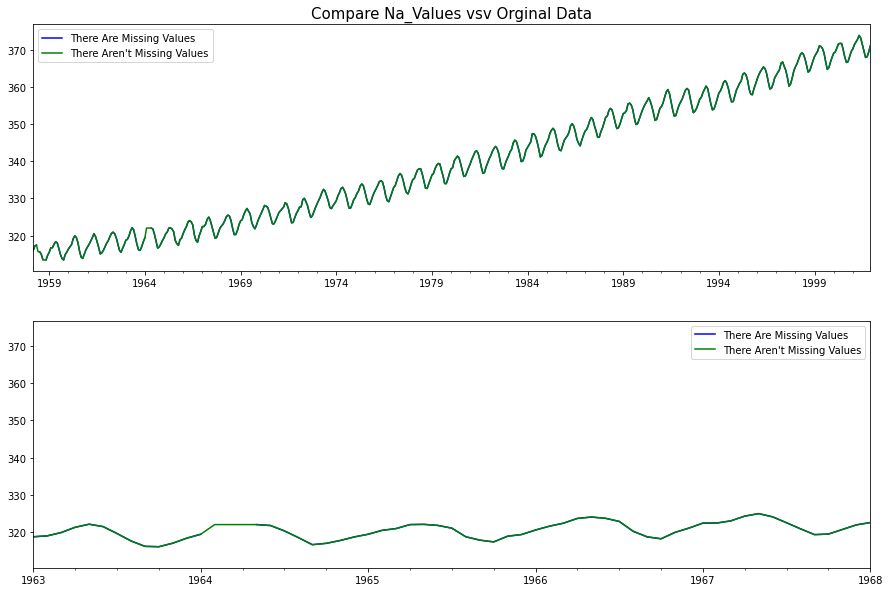

In [16]:
plt.figure(figsize = (15,10))

plt.subplot(2,1,1)
y["co2"].plot( color = "b",label = "There Are Missing Values")
y["co2_Na_Values"].plot(color = "g", label = "There Aren't Missing Values")
plt.legend(loc = "best")
plt.title("Compare Na_Values vsv Orginal Data",fontsize = 15)

plt.subplot(2,1,2)
y["co2"].plot( color = "b",label = "There Are Missing Values")
y["co2_Na_Values"].plot(color = "g", label = "There Aren't Missing Values")
plt.xlim(["1963","1968"])

plt.legend(loc="best")
plt.show()

In [17]:
# We Take Series Attention !!!

import statsmodels.api as sm

y = sm.datasets.co2.load_pandas().data
y = y["co2"].resample("MS").mean()
y = y.fillna(y.bfill())
type(y)

pandas.core.series.Series

In [18]:
# There Aren't Na Values...

y.isnull().sum()

0

In [19]:
pd.DataFrame(y).head(20).T

,1958-03-01,1958-04-01,1958-05-01,1958-06-01,1958-07-01,1958-08-01,1958-09-01,1958-10-01,1958-11-01,1958-12-01,1959-01-01,1959-02-01,1959-03-01,1959-04-01,1959-05-01,1959-06-01,1959-07-01,1959-08-01,1959-09-01,1959-10-01
co2,316.1000,317.2000,317.4333,315.6250,315.6250,314.9500,313.5000,313.4250,313.4250,314.7000,315.5000,316.7000,316.7333,317.6750,318.3250,318.0250,316.5250,314.9000,313.8250,313.4000


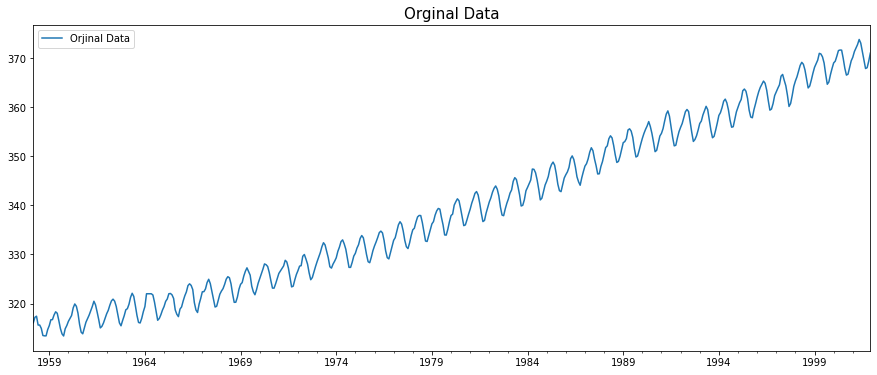

In [20]:
y.plot(figsize = (15,6), label = "Orjinal Data")
plt.title("Orginal Data", fontsize = 15)
plt.legend(loc = "best")
plt.show()

In [21]:
############################
# Holdout
############################

In [22]:
# Train set from 1958 to the end of 1997
# We want to predict 48 months ahead...

In [23]:
train_number = len(y)-48
train_number

478

In [24]:
train = y.iloc[:train_number]
test = y.iloc[train_number:]

print("Train Shape : {}".format(train.shape))
print("Test Shape : {}".format(test.shape))

Train Shape : (478,)
Test Shape : (48,)


In [25]:
# For Train 

print("Min Date Train : {}".format(train.index.min()))
print("Max Date Train : {}".format(train.index.max()))

Min Date Train : 1958-03-01 00:00:00
Max Date Train : 1997-12-01 00:00:00


In [26]:
# For Test

print("Min Date Train : {}".format(test.index.min()))
print("Max Date Train : {}".format(test.index.max()))

Min Date Train : 1998-01-01 00:00:00
Max Date Train : 2001-12-01 00:00:00


In [27]:
################################################
# Time Series Structural Analysis
################################################

In [28]:
# Stability Test (Dickey - Fuller Test)

In [29]:
from statsmodels.tsa.api import adfuller

In [30]:
def is_stationary(model , plot = False):
    
    print("""
    *************************
    H0 : Non-Stationary
    H1 : Stationary
    *************************
    """)
    
    from statsmodels.tsa.api import adfuller
    
    p_value = adfuller(model)[1]
    
    if p_value < 0.05 :
        
        print(f"Results : Stationary (H0: Non-Stationary , p-value : {round(p_value,4)})")
        
    else:
        
        print(f"Results : Non-Stationary (H0 : Non-Stationary , p-value : {round(p_value,4)})")
        
    
    if plot :
        
        plt.figure(figsize = (15,6))
        plt.plot(y)
        plt.title(f"Graph For CO2 (P-Value : {round(p_value,3)})", fontsize = 15)
        plt.show()


    *************************
    H0 : Non-Stationary
    H1 : Stationary
    *************************
    
Results : Non-Stationary (H0 : Non-Stationary , p-value : 0.999)


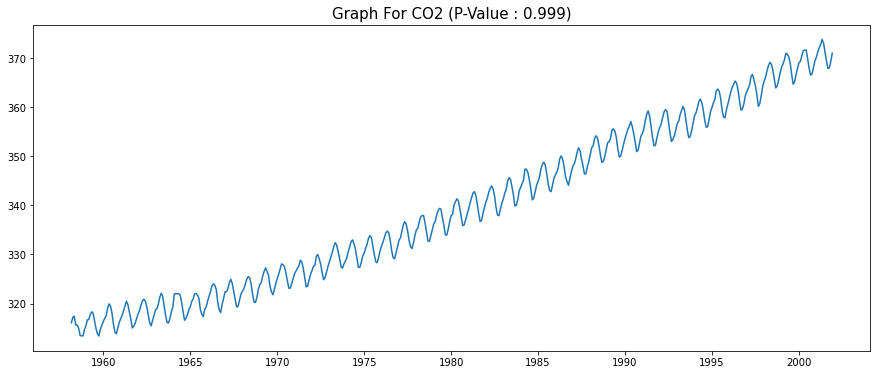

In [31]:
# P_Values < 0.05 Red
# P_Values < 0.05 değilse Red edilemez...

is_stationary(y,plot = True)

In [32]:
def ts_decompose(y, model = "additive",stationary = False):
    
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    result = seasonal_decompose(y , model = model)
    
    fig , axes = plt.subplots(4,1, sharex= True ,sharey = False)
    
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    axes[0].set_title("Decompose For " + model.upper() + " Model", fontsize = 15)
    axes[0].plot(y, "k", label = "Orginal "+ model.upper())
    axes[0].legend(loc = "upper left")
    
    axes[1].plot(result.trend, "r", label = "Trend")
    axes[1].legend(loc = "upper left")
    
    axes[2].plot(result.seasonal, "g", label = "Seasonility & Mean : " + str(round(result.seasonal.mean(),4)))
    axes[2].legend(loc = "upper left")
    
    axes[3].plot(result.resid , "b", label = "Residuals & Mean : " + str(round(result.resid.mean(),4 )))
    axes[3].legend(loc = "upper left")
    
    
    if stationary:
        
        is_stationary(y, plot = False)


    *************************
    H0 : Non-Stationary
    H1 : Stationary
    *************************
    
Results : Non-Stationary (H0 : Non-Stationary , p-value : 0.999)


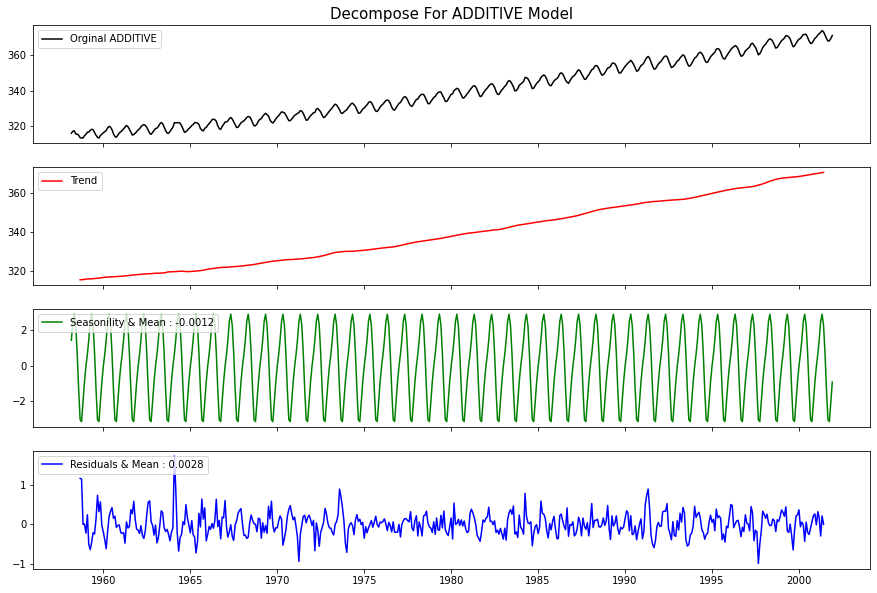

In [33]:
ts_decompose(y,model = "additive", stationary=True)

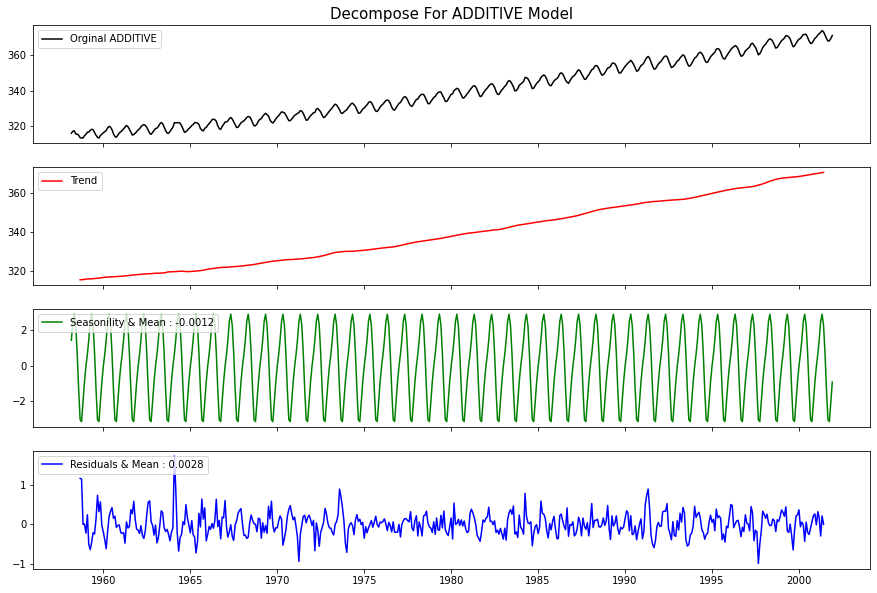

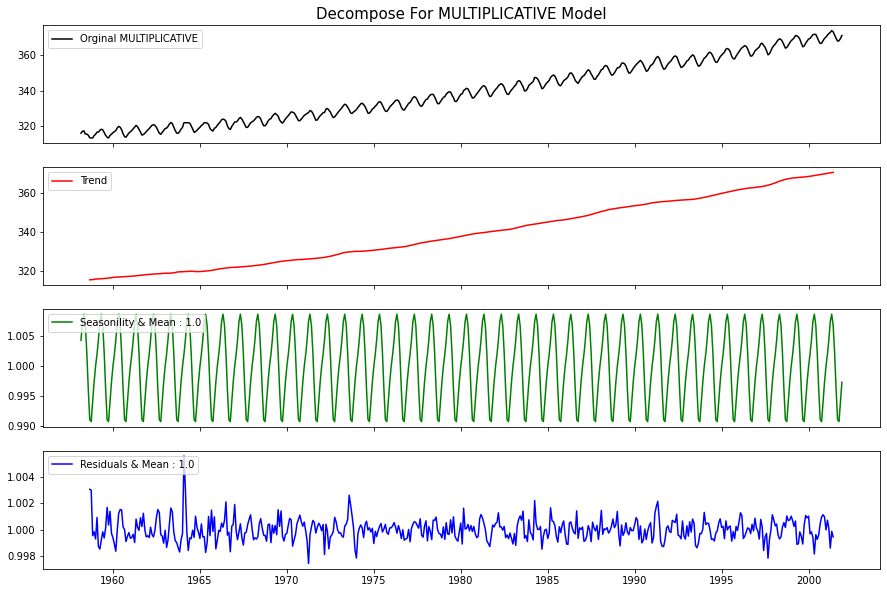

In [34]:
# Analysis for additive and multiplicative models

# y(t) = Level + Trend + Seasonality + Noise
# y(t) = Level * Trend * Seasonality * Noise

for model in ["additive","multiplicative"]:
    ts_decompose(y, model,stationary=False)

In [35]:
################################################
# Single Exponential Smoothing
################################################

# SOUND = Level
# Used in stationary series.
# Cannot be used if there are trends and seasonality.

In [36]:
# We need to check simple model 

def plot_co2_graph(train,test,y_pred,title):
    
    mae = mean_absolute_error(test,y_pred)
    title = title + f" (MAE : {round(mae, 4)})"
    plt.figure(figsize = (15,7))
    
    train["1985":].plot(label = "TRAIN")
    test.plot(label = "TEST")
    y_pred.plot(label = "PREDICTION")
    
    plt.legend(loc = "upper left")
    plt.title(title , fontsize = 15)
    plt.show()

In [37]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error

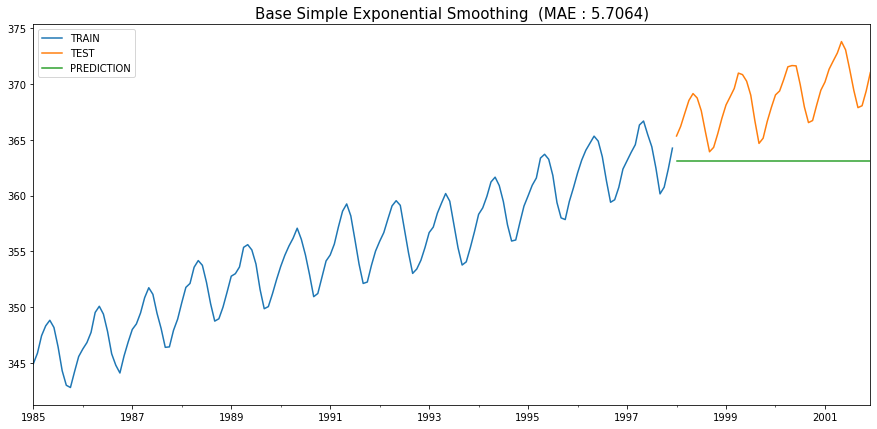

In [38]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)
ses_y_pred = ses_model.forecast(steps = 48)

plot_co2_graph(train,test,ses_y_pred, title = "Base Simple Exponential Smoothing ")

In [39]:
########################################################
# Hyperparameter Optimization & FINAL SES Model
########################################################

In [40]:
def ses_optimizer(train,test,alphas,steps = 48):
    
    best_alpha, best_mae = None, float("inf")
    
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level = alpha)
        ses_y_pred = ses_model.forecast(steps = steps)
        ses_mae = mean_absolute_error(test, ses_y_pred)
        
        if ses_mae < best_mae:
            
            best_alpha, best_mae = alpha,ses_mae
            
        print(f"Alpha : {round(alpha,4)}, MAE : {round(ses_mae,4)}")
        
    print("\n\n")
    print(f"Best Alpha : {round(best_alpha,4)}, Best MAE : {round(best_mae,4)}")
    
    return best_alpha

In [41]:
alphas = np.arange(0.8 ,1 ,0.01)

ses_best_alpha = ses_optimizer(train , test , alphas , steps = 48)

Alpha : 0.8, MAE : 4.953
Alpha : 0.81, MAE : 4.9282
Alpha : 0.82, MAE : 4.9035
Alpha : 0.83, MAE : 4.8792
Alpha : 0.84, MAE : 4.8551
Alpha : 0.85, MAE : 4.8316
Alpha : 0.86, MAE : 4.8091
Alpha : 0.87, MAE : 4.7869
Alpha : 0.88, MAE : 4.765
Alpha : 0.89, MAE : 4.7434
Alpha : 0.9, MAE : 4.7221
Alpha : 0.91, MAE : 4.7012
Alpha : 0.92, MAE : 4.6805
Alpha : 0.93, MAE : 4.6602
Alpha : 0.94, MAE : 4.6402
Alpha : 0.95, MAE : 4.6205
Alpha : 0.96, MAE : 4.6012
Alpha : 0.97, MAE : 4.5822
Alpha : 0.98, MAE : 4.5634
Alpha : 0.99, MAE : 4.5451



Best Alpha : 0.99, Best MAE : 4.5451


In [42]:
def final_ses_graph(train, test, best_alpha, steps = 48):
    
    final_ses_model = SimpleExpSmoothing(train).fit(smoothing_level = best_alpha)
    final_ses_y_pred = final_ses_model.forecast(steps)
    final_ses_mae = mean_absolute_error(test, final_ses_y_pred)
    
    title = f"Simple Exponential Smoothing (MAE : {round(final_ses_mae , 4)} , Alpha : {round(best_alpha,4)})"
    title = "Optimizer " + title
    
    plt.figure(figsize = (15,7))
    train["1985":].plot(label = "TRAIN")
    test.plot(label = "TEST")
    final_ses_y_pred.plot(label = "PREDICTION")
    
    plt.title(title , fontsize = 15)
    plt.legend(loc = "upper left")
    plt.show()

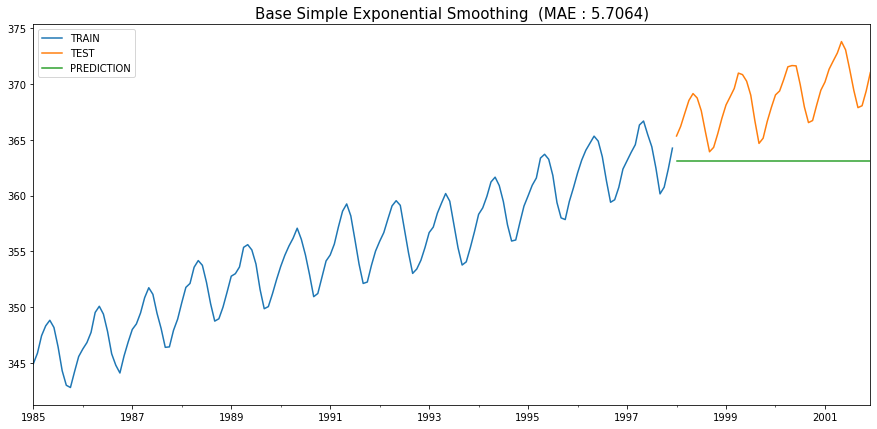

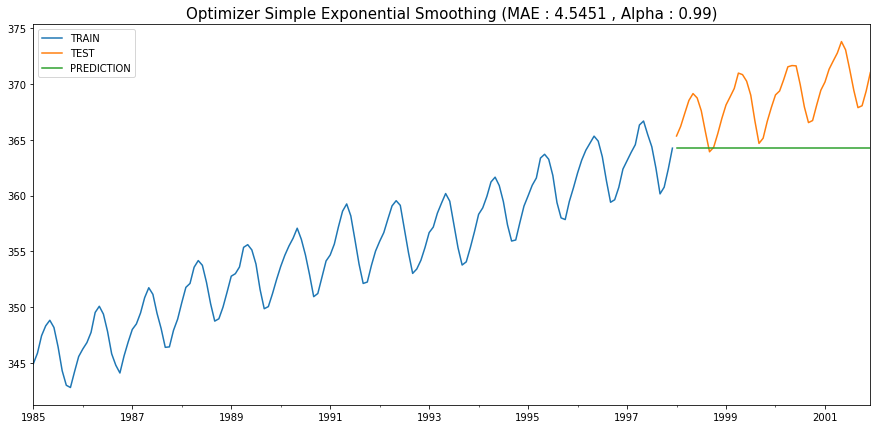

In [43]:
plot_co2_graph(train,test,ses_y_pred,title = "Base Simple Exponential Smoothing ")
final_ses_graph(train, test, ses_best_alpha, steps = 48)

In [44]:
################################################
# Double Exponential Smoothing (DES)
################################################

# DES: Level (SES) + Trend

# In addition to Level, it can catch the Trend.

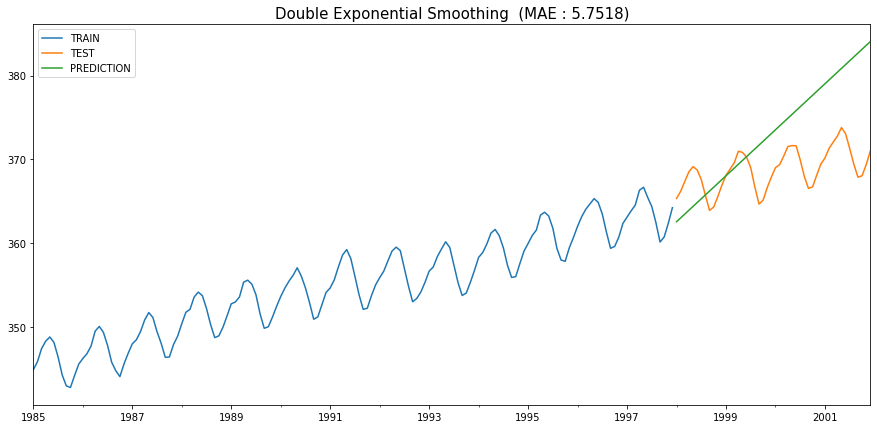

In [45]:
des_model = ExponentialSmoothing(train,trend = "add").fit(smoothing_level = 0.5, \
                                                          smoothing_trend = 0.5)

des_y_pred = des_model.forecast(steps = 48)

plot_co2_graph(train, test , des_y_pred, "Double Exponential Smoothing ")

In [46]:
########################################################
# Hyperparameter Optimization & Des Model
########################################################

In [47]:
def des_optimizer(train, test, alphas, betas, trend = "add", steps = 48):
    
    best_alpha, best_beta ,best_mae = None, None, float("inf")
    
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train,trend = "add").fit(smoothing_level = alpha,
                                                                      smoothing_trend = beta)
            des_y_pred = des_model.forecast(steps = steps)
            des_mae = mean_absolute_error(test, des_y_pred)
            
            if des_mae < best_mae:
                
                best_alpha,best_beta,best_mae = alpha,beta,des_mae
                
            print(f"Alpha : {round(alpha,4)}, Beta : {round(beta,4)}, MAE : {round(des_mae , 4)}")
            
    
    print("\n\n")
    print(f"Best Alpha : {round(best_alpha,4)}, Best Beta : {round(best_beta,4)},Best MAE : {round(best_mae,4)}")
    
    return best_alpha, best_beta

In [48]:
alphas = np.arange(0.01,1,0.1)
betas = np.arange(0.01,1,0.1)

des_best_alpha,des_best_beta = des_optimizer(train, test, alphas,betas,trend = "add", steps =48)

Alpha : 0.01, Beta : 0.01, MAE : 2.3849
Alpha : 0.01, Beta : 0.11, MAE : 2.8294
Alpha : 0.01, Beta : 0.21, MAE : 2.744
Alpha : 0.01, Beta : 0.31, MAE : 2.1723
Alpha : 0.01, Beta : 0.41, MAE : 2.8895
Alpha : 0.01, Beta : 0.51, MAE : 2.49
Alpha : 0.01, Beta : 0.61, MAE : 1.8196
Alpha : 0.01, Beta : 0.71, MAE : 1.7411
Alpha : 0.01, Beta : 0.81, MAE : 2.1932
Alpha : 0.01, Beta : 0.91, MAE : 4.8522
Alpha : 0.11, Beta : 0.01, MAE : 2.4334
Alpha : 0.11, Beta : 0.11, MAE : 3.9118
Alpha : 0.11, Beta : 0.21, MAE : 6.0908
Alpha : 0.11, Beta : 0.31, MAE : 7.2434
Alpha : 0.11, Beta : 0.41, MAE : 8.7305
Alpha : 0.11, Beta : 0.51, MAE : 10.3166
Alpha : 0.11, Beta : 0.61, MAE : 12.0066
Alpha : 0.11, Beta : 0.71, MAE : 13.9772
Alpha : 0.11, Beta : 0.81, MAE : 16.4873
Alpha : 0.11, Beta : 0.91, MAE : 19.655
Alpha : 0.21, Beta : 0.01, MAE : 2.8218
Alpha : 0.21, Beta : 0.11, MAE : 5.7217
Alpha : 0.21, Beta : 0.21, MAE : 8.6538
Alpha : 0.21, Beta : 0.31, MAE : 11.7598
Alpha : 0.21, Beta : 0.41, MAE : 15.52

In [49]:
def final_des_graph(train,test,best_alpha,best_beta,steps=48):
    
    final_des_model = ExponentialSmoothing(train,trend = "add").fit(smoothing_level = best_alpha,\
                                                                    smoothing_trend = best_beta)
    final_des_y_pred= final_des_model.forecast(steps = steps)
    
    final_des_mae = mean_absolute_error(test, final_des_y_pred)
    
    title = "Double Exponential Smoothing"
    title = title + f" (MAE : {round(final_des_mae,4)}, Alpha : {round(best_alpha,4)}, Beta : {round(best_beta,4)})"
    title = "Optimizer " + title
    
    plt.figure(figsize = (15,7))
    train["1985":].plot(label = "TRAIN")
    test.plot(label = "TEST")
    final_des_y_pred.plot(label = "PREDICTION")
    
    plt.title(title, fontsize = 15)
    plt.legend(loc = "upper left")
    plt.show()

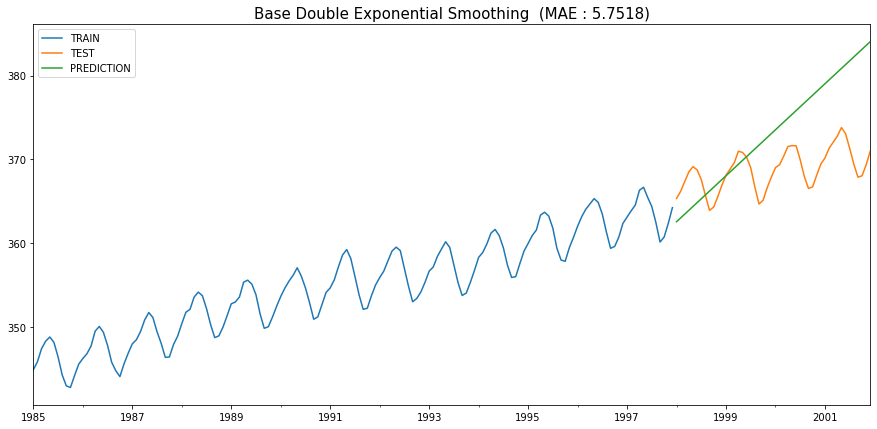

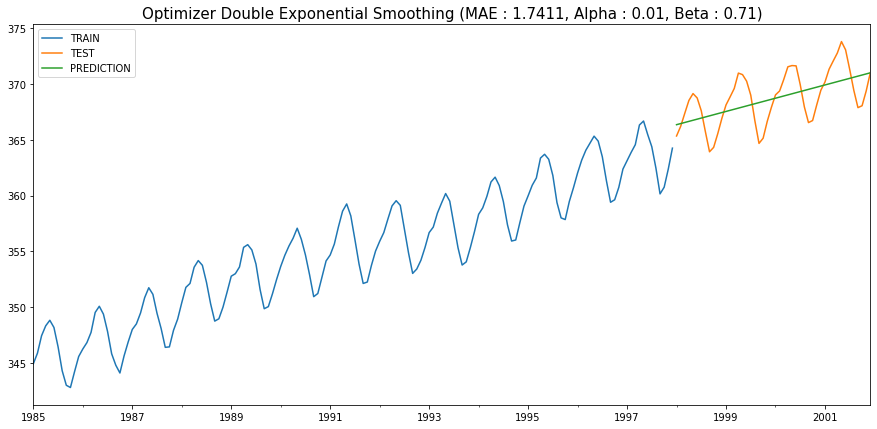

In [50]:
plot_co2_graph(train,test,des_y_pred,title = "Base Double Exponential Smoothing ")
final_des_graph(train,test,des_best_alpha,des_best_beta,steps = 48)

In [51]:
################################################
# Triple Exponential Smoothing (Holt-Winters)
################################################


# TES = SES + DES + Seasonality

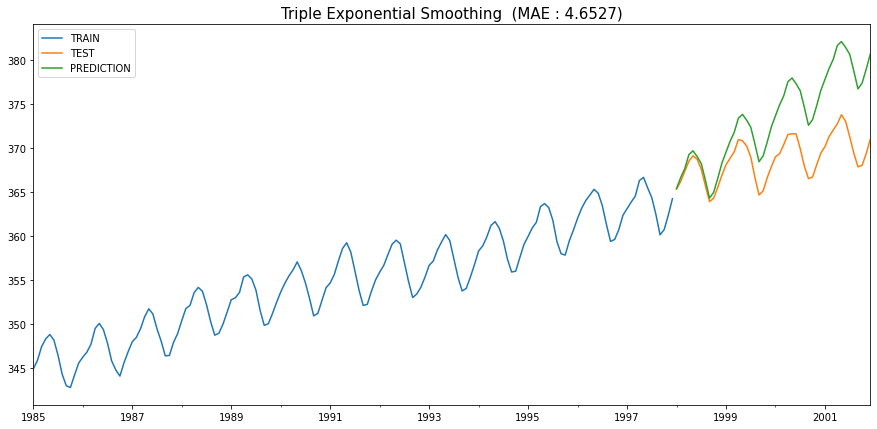

In [52]:
tes_model = ExponentialSmoothing(train,
                                  trend = "add",
                                  seasonal="add",
                                  seasonal_periods=12).fit(smoothing_level=0.5,
                                                           smoothing_trend=0.5,
                                                           smoothing_seasonal=0.5)

tes_y_pred = tes_model.forecast(steps = 48)

plot_co2_graph(train, test, tes_y_pred, title = "Triple Exponential Smoothing ")

In [53]:
########################################################
# Hyperparameter Optimization & Tes Model
########################################################

In [54]:
def tes_optimizer(train, test, abg ,trend = "add",seasonal = "add",seasonal_periods = 12, steps =48):
    
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    
    for comb in abg:
        
        tes_model = ExponentialSmoothing(train,
                                          trend=trend,
                                          seasonal=seasonal,
                                          seasonal_periods=seasonal_periods).fit(smoothing_level = comb[0],
                                                                                 smoothing_trend = comb[1],
                                                                                 smoothing_seasonal = comb[2])
        tes_y_pred = tes_model.forecast(steps = steps)
        
        tes_mae = mean_absolute_error(test, tes_y_pred)
        
        if tes_mae < best_mae:
            
            best_alpha,best_beta,best_gamma,best_mae = comb[0],comb[1],comb[2],tes_mae
        
        
        
        print(f"Alpha : {round(comb[0],3)},Beta : {round(comb[1],3)},Gamma : {round(comb[2],3)},MAE : {round(tes_mae,3)}")
    
    print("\n\n")
    print(f"Best Alpha : {round(best_alpha,3)},Best Beta : {round(best_beta,3)},Best Gamma : {round(best_gamma,3)},Best MAE : {round(best_mae,3)},")
    
    return best_alpha,best_beta,best_gamma

In [55]:
import itertools

alphas = betas = gammas = np.arange(0.1, 1, 0.2)
abg = list(itertools.product(alphas, betas, gammas))

tes_best_alpha,tes_best_beta,tes_best_gamma = tes_optimizer(train,
                                                            test,
                                                            abg,
                                                            trend = "add",
                                                            seasonal="add",
                                                            seasonal_periods=12,
                                                            steps = 48)

Alpha : 0.1,Beta : 0.1,Gamma : 0.1,MAE : 1.504
Alpha : 0.1,Beta : 0.1,Gamma : 0.3,MAE : 1.512
Alpha : 0.1,Beta : 0.1,Gamma : 0.5,MAE : 1.546
Alpha : 0.1,Beta : 0.1,Gamma : 0.7,MAE : 1.569
Alpha : 0.1,Beta : 0.1,Gamma : 0.9,MAE : 1.592
Alpha : 0.1,Beta : 0.3,Gamma : 0.1,MAE : 1.865
Alpha : 0.1,Beta : 0.3,Gamma : 0.3,MAE : 1.671
Alpha : 0.1,Beta : 0.3,Gamma : 0.5,MAE : 1.597
Alpha : 0.1,Beta : 0.3,Gamma : 0.7,MAE : 1.511
Alpha : 0.1,Beta : 0.3,Gamma : 0.9,MAE : 1.409
Alpha : 0.1,Beta : 0.5,Gamma : 0.1,MAE : 0.86
Alpha : 0.1,Beta : 0.5,Gamma : 0.3,MAE : 0.749
Alpha : 0.1,Beta : 0.5,Gamma : 0.5,MAE : 0.788
Alpha : 0.1,Beta : 0.5,Gamma : 0.7,MAE : 0.79
Alpha : 0.1,Beta : 0.5,Gamma : 0.9,MAE : 0.706
Alpha : 0.1,Beta : 0.7,Gamma : 0.1,MAE : 1.4
Alpha : 0.1,Beta : 0.7,Gamma : 0.3,MAE : 1.684
Alpha : 0.1,Beta : 0.7,Gamma : 0.5,MAE : 1.4
Alpha : 0.1,Beta : 0.7,Gamma : 0.7,MAE : 3.242
Alpha : 0.1,Beta : 0.7,Gamma : 0.9,MAE : 4.715
Alpha : 0.1,Beta : 0.9,Gamma : 0.1,MAE : 2.324
Alpha : 0.1,Beta : 

In [56]:
def final_tes_graph(train,test,best_alpha,best_beta,best_gamma,trend="add",
                    seasonal="add",seasonal_periods = 12,steps = 48):
    
    final_tes_model = ExponentialSmoothing(train,
                                           trend=trend,
                                           seasonal=seasonal,
                                           seasonal_periods=seasonal_periods).fit(smoothing_level=best_alpha,
                                                                                  smoothing_trend=best_beta,
                                                                                  smoothing_seasonal=best_gamma)
    
    final_tes_y_pred = final_tes_model.forecast(steps = steps )
    
    final_tes_mae = mean_absolute_error(test, final_tes_y_pred)
    
    title = "Triple Exponential Smoothing "
    title = title + f"(MAE : {round(final_tes_mae,4)},Alpha : {round(best_alpha,4)},Beta : {round(best_beta,4)},Gamma : {round(best_gamma,4)})"
    title = "Optimizer " + title
    
    plt.figure(figsize = (15,7))
    train["1985": ].plot(label = "TRAIN")
    test.plot(label = "TEST")
    final_tes_y_pred.plot(legend = "PREDICTION")
    
    plt.title(title, fontsize = 15)
    plt.legend(loc = "upper left")
    plt.show()

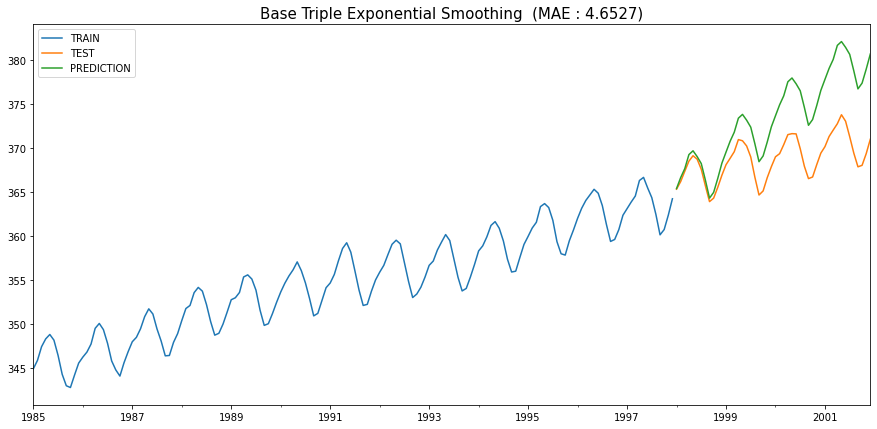

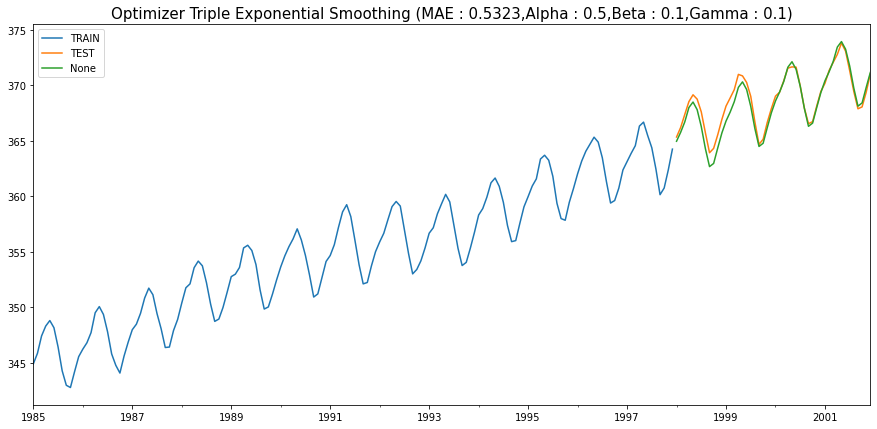

In [57]:
plot_co2_graph(train,test,tes_y_pred,title = "Base Triple Exponential Smoothing ")
final_tes_graph(train,test,tes_best_alpha,tes_best_beta,tes_best_gamma)

---

## Comparison Base Vs Optimizer

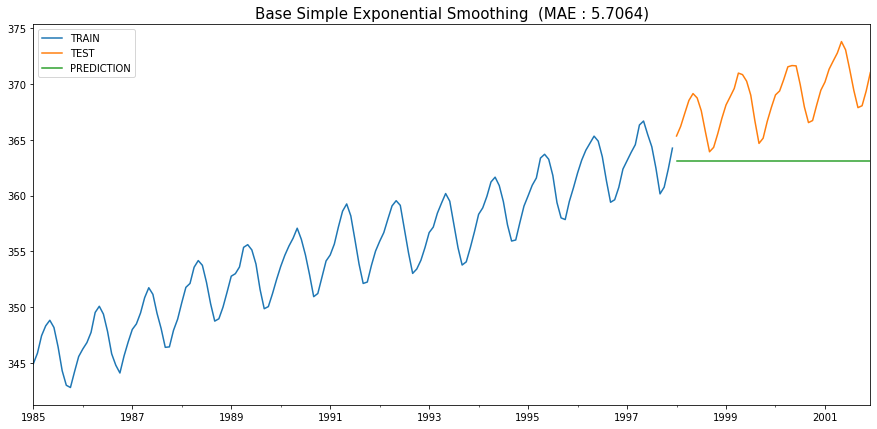

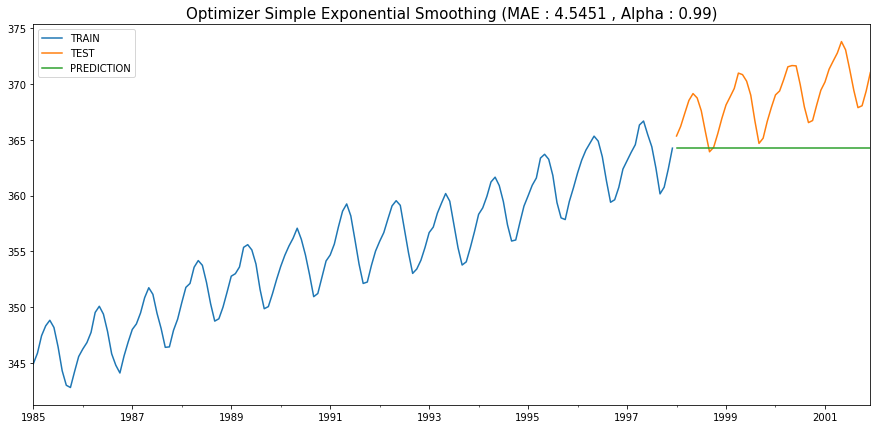

In [58]:
plot_co2_graph(train, test, ses_y_pred, "Base Simple Exponential Smoothing ")
final_ses_graph(train,test, ses_best_alpha)

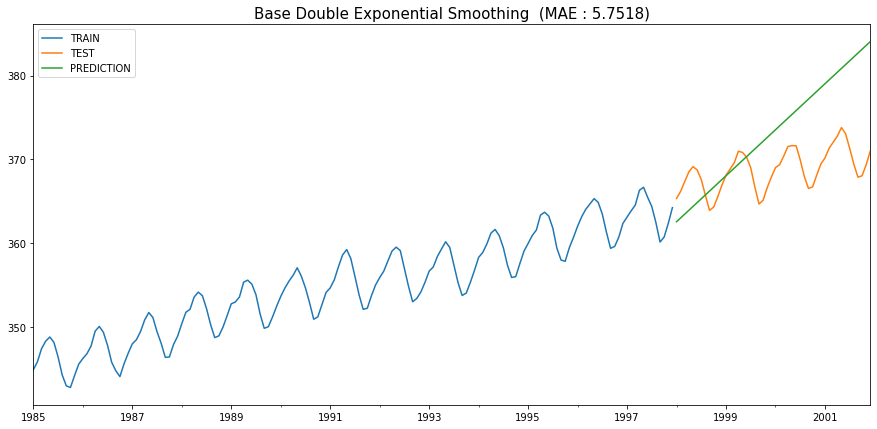

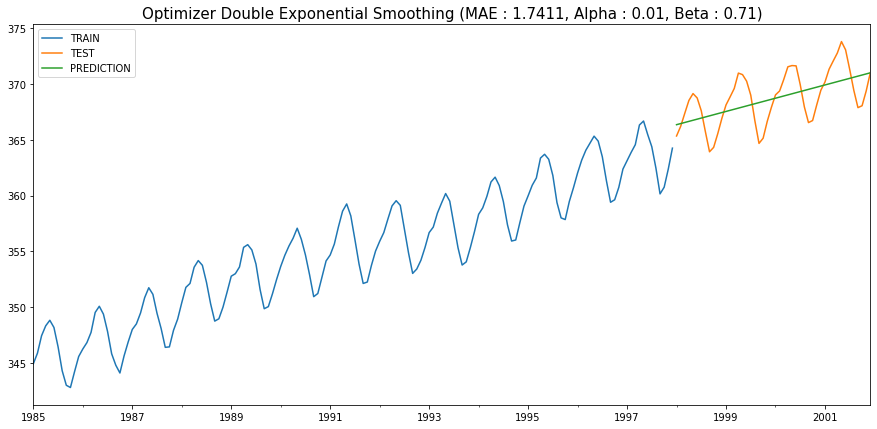

In [59]:
plot_co2_graph(train, test, des_y_pred, "Base Double Exponential Smoothing ")
final_des_graph(train,test, des_best_alpha,des_best_beta)

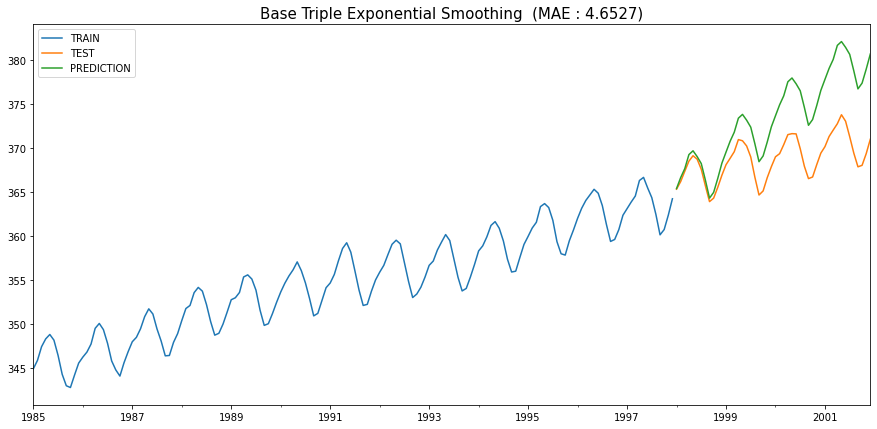

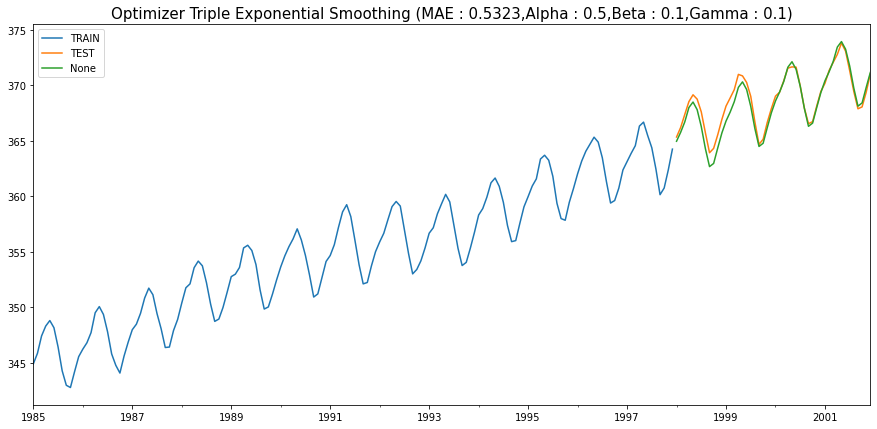

In [60]:
plot_co2_graph(train, test, tes_y_pred, "Base Triple Exponential Smoothing ")
final_tes_graph(train,test, tes_best_alpha, tes_best_beta,tes_best_gamma)

---

In [61]:
##################################################
# ARIMA(p, d, q): (Autoregressive Integrated Moving Average)
##################################################

In [62]:
from statsmodels.tsa.arima_model import ARIMA

In [63]:
# p : Geçmiş Gerçek Değer Geçikme Sayısı
# q : Geçmiş Artık hatalardaki geçikme sayısı
# d : Fark İşlemi Sayısı (Fark Derecesi ,1)

# p : Past Actual Value Latency Count
# q : History Number of delays in residual errors
# d : Number of Difference Operations (Differential Degree ,1)

# disp = verbose

arima_model = ARIMA(train ,order = (1,1,1)).fit(disp = 0)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                  D.co2   No. Observations:                  477
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -747.585
Method:                       css-mle   S.D. of innovations              1.159
Date:                Mon, 27 Sep 2021   AIC                           1503.170
Time:                        20:36:00   BIC                           1519.840
Sample:                    04-01-1958   HQIC                          1509.725
                         - 12-01-1997                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1046      0.009     11.367      0.000       0.087       0.123
ar.L1.D.co2     0.8643      0.027     31.780      0.000       0.811       0.918
ma.L1.D.co2    -0.9786      0.009   -104.770      0.000      -0.997      -0.960
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1571           +0.0000j            1.1571            0.0000
MA.1            1.0218           +0.0000j            1.0218            0.0000
-----------------------------------------------------------------------------
"""

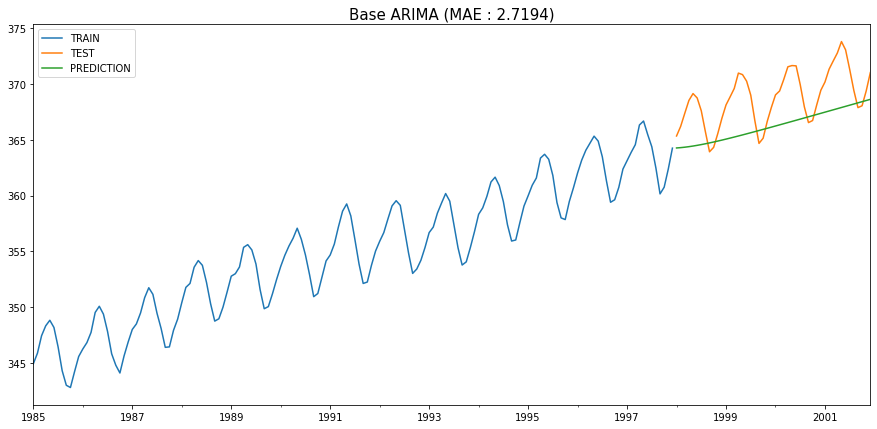

In [64]:
# Burda indexler belirlenmiyor bizim eklememiz lazım 
# Arıma sadece trend ve level yakalayabiliyor...

# Indexes are not determined here, we need to add
# Arima can only catch trend and level...

arima_y_pred = arima_model.forecast(steps = 48)[0]
arima_y_pred = pd.Series(data = arima_y_pred, index = test.index)
plot_co2_graph(train, test, arima_y_pred, "Base ARIMA")

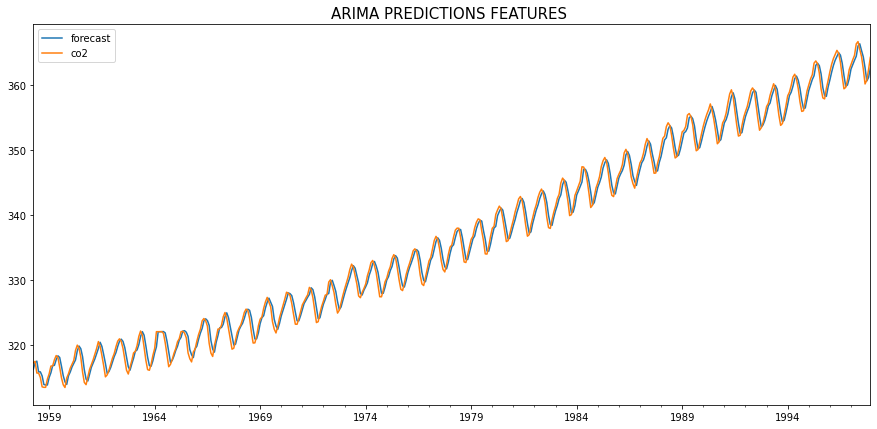

In [65]:
# Buda kendi özelliği

# Here is its own feature

fig,axes = plt.subplots(1,1,figsize =(15,7))

arima_model.plot_predict(ax = axes, dynamic = False)
plt.title("ARIMA PREDICTIONS FEATURES ",fontsize = 15)
plt.show()

In [66]:
############################
# Hyperparameter Optimization (Model Derecelerini Belirleme)
############################

# 1. AIC İstatistiğine Göre Model Derecesini Belirleme
# 2. ACF & PACF Grafiklerine Göre Model Derecesini Belirleme

############################
# AIC & BIC İstatistiklerine Göre Model Derecesini Belirleme
############################


############################
# Hyperparameter Optimization (Determining Model Grades)
############################

#1. Determining Model Grade Based on AIC Statistics
#2. Determining Model Grade Based on ACF & PACF Charts

############################
# Determining Model Grade Based on AIC & BIC Statistics
############################


# Akaike ölçütü (Akaike information criterion-AIC) belirli bir veri kümesi için kaliteli 
# bir istatistiksel göreceli model ölçüsüdür. 
# Yani, veri modelleri koleksiyonu verildiğinde, AIC her model kalitesini, diğer modellerin her birini göreceli olarak tahmin ediyor.
# Dolayısıyla, AIC model seçimi için bir yol sağlar.

# Akaike criterion (Akaike information criterion-AIC) for a given dataset with good quality
# is a statistical relative model measure.
# That is, given a collection of data models, AIC predicts each model quality relative to each of the other models.
# Hence, AIC provides a way for model selection.

In [67]:
p = d = q =range(0,4)
pdq = list(itertools.product(p,d,q))

def arima_optimizer_aic(train,orders):
    
    best_aic, best_params = float("inf"), None
    
    for order in orders:
        try:
            arima_model_results =ARIMA(train, order = order).fit(disp = 0)
            aic = arima_model_results.aic
            if aic < best_aic:
                best_aic, best_params = aic , order
        
            print(f"AIC : {round(aic,4)} , Order : {order}")
        
        except :
            continue 
    
    print("\n\n")
    print(f"Best AIC : {round(best_aic , 4)} ,Best Order : {best_params}")
    
    return best_params

In [68]:
def arima_optimizer_mae(train,test,orders):
    
    best_mae, best_params = float("inf"), None
    
    for order in orders:
       
        try:
            arima_model = ARIMA(train, order = order).fit(disp = 0)
            arima_y_pred = arima_model.forecast(steps = 48)[0]
            mae = mean_absolute_error(test, arima_y_pred)
        
            if mae < best_mae:
            
                best_mae , best_params = mae, order
            
            
            print(f"MAE : {round(mae, 4)}, Order : {order}")
        
        except:
            continue
            
    print("\n\n")
    print(f"Best MAE : {round(best_mae,4)}, Best Order : {best_params}")
    
    return best_params

In [69]:
arima_best_params_mae = arima_optimizer_mae(train, test, pdq)

MAE : 32.0647, Order : (0, 0, 0)
MAE : 31.7328, Order : (0, 0, 1)
MAE : 2.4133, Order : (0, 1, 0)
MAE : 1.9731, Order : (0, 1, 1)
MAE : 1.987, Order : (0, 1, 2)
MAE : 1.8597, Order : (0, 1, 3)
MAE : 41.9621, Order : (0, 2, 0)
MAE : 42.6913, Order : (0, 2, 1)
MAE : 35.6672, Order : (0, 2, 2)
MAE : 1.8668, Order : (0, 2, 3)
MAE : 5.5126, Order : (1, 0, 0)
MAE : 5.2921, Order : (1, 0, 1)
MAE : 6.4576, Order : (1, 0, 2)
MAE : 8.0963, Order : (1, 0, 3)
MAE : 2.3121, Order : (1, 1, 0)
MAE : 2.7194, Order : (1, 1, 1)
MAE : 43.5227, Order : (1, 2, 0)
MAE : 8.2855, Order : (2, 0, 0)
MAE : 7.4864, Order : (2, 0, 1)
MAE : 4.9472, Order : (2, 0, 2)
MAE : 1.9925, Order : (2, 1, 0)
MAE : 1.5067, Order : (2, 1, 2)
MAE : 1.5564, Order : (2, 1, 3)
MAE : 41.9316, Order : (2, 2, 0)
MAE : 6.3264, Order : (3, 0, 0)
MAE : 3.3893, Order : (3, 0, 2)
MAE : 1.6578, Order : (3, 0, 3)
MAE : 2.4618, Order : (3, 1, 0)
MAE : 12.2878, Order : (3, 2, 0)



Best MAE : 1.5067, Best Order : (2, 1, 2)


In [70]:
arima_best_params_aic = arima_optimizer_aic(train, pdq)

AIC : 3954.0123 , Order : (0, 0, 0)
AIC : 3312.7322 , Order : (0, 0, 1)
AIC : 1522.4854 , Order : (0, 1, 0)
AIC : 1254.4433 , Order : (0, 1, 1)
AIC : 1138.375 , Order : (0, 1, 2)
AIC : 1095.4305 , Order : (0, 1, 3)
AIC : 1281.8122 , Order : (0, 2, 0)
AIC : 1259.8891 , Order : (0, 2, 1)
AIC : 1249.7451 , Order : (0, 2, 2)
AIC : 1143.4276 , Order : (0, 2, 3)
AIC : 1536.5892 , Order : (1, 0, 0)
AIC : 1267.2232 , Order : (1, 0, 1)
AIC : 1149.9668 , Order : (1, 0, 2)
AIC : 1105.7167 , Order : (1, 0, 3)
AIC : 1208.9988 , Order : (1, 1, 0)
AIC : 1503.1702 , Order : (1, 1, 1)
AIC : 1258.0537 , Order : (1, 2, 0)
AIC : 1217.8589 , Order : (2, 0, 0)
AIC : 1168.3734 , Order : (2, 0, 1)
AIC : 1265.8899 , Order : (2, 0, 2)
AIC : 1103.7981 , Order : (2, 1, 0)
AIC : 855.3351 , Order : (2, 1, 2)
AIC : 800.7454 , Order : (2, 1, 3)
AIC : 1259.1382 , Order : (2, 2, 0)
AIC : 1115.6078 , Order : (3, 0, 0)
AIC : 971.7667 , Order : (3, 0, 2)
AIC : 1356.5895 , Order : (3, 0, 3)
AIC : 1048.8399 , Order : (3, 1,

In [71]:
def final_arima_aic(train, test, best_params, steps = 48 ):
    
    final_arima_model_aic = ARIMA(train, order = best_params).fit(disp = 0)
    final_y_pred_aic = final_arima_model_aic.forecast(steps = steps )[0]
    final_aic = final_arima_model_aic.aic
    predictions = pd.Series(data = final_y_pred_aic, index = test.index)
    
    
    title = f"Optimizer ARIMA Model (AIC : {round(final_aic, 4)}, Order : {best_params} )"
    plt.figure(figsize = (15,7))
    train["1985":].plot(label = "TRAIN")
    test.plot(label = "TEST")
    predictions.plot(label = "PREDICTION")
    
    plt.title(title, fontsize = 15)
    plt.legend(loc = "upper left")
    plt.show()

In [72]:
def final_arima_mae(train,test,best_params, steps = 48):
    
    final_arima_model_mae = ARIMA(train , order = best_params).fit(disp = 0)
    final_y_pred_mae = final_arima_model_mae.forecast(steps = steps)[0]
    final_mae = mean_absolute_error(test, final_y_pred_mae)
    predictions = pd.Series(data = final_y_pred_mae, index = test.index)
    
    title = f"Optimizer ARIMA Model (MAE : {round(final_mae, 4)}, Order : {best_params} )"
    plt.figure(figsize = (15,7))
    train["1985":].plot(label = "TRAIN")
    test.plot(label = "TEST")
    predictions.plot(label = "PREDICTION")
    
    plt.title(title, fontsize = 15)
    plt.legend(loc = "upper left")
    plt.show()

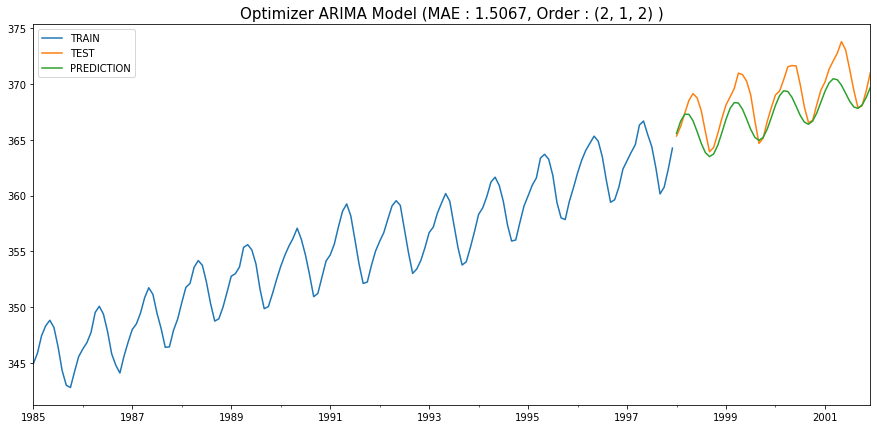

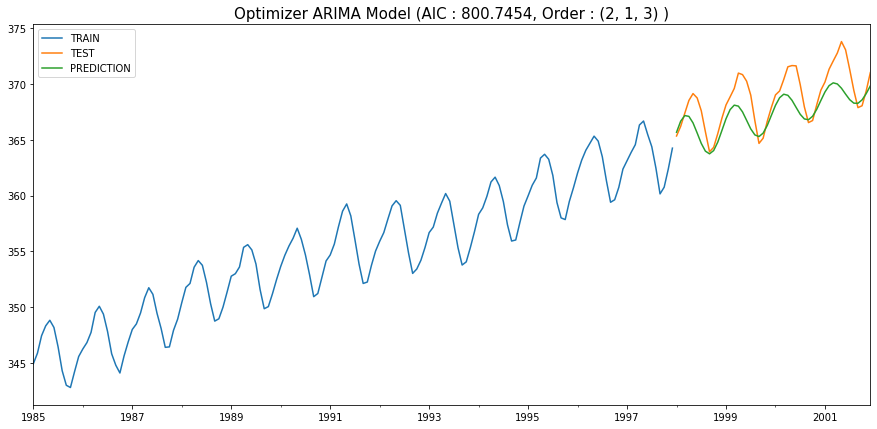

In [73]:
final_arima_mae(train,test,arima_best_params_mae,steps = 48)
final_arima_aic(train,test,arima_best_params_aic,steps = 48)

In [74]:
############################
# ACF & PACF Grafiklerine Göre Model Derecesini Belirleme
############################

############################
# Determining Model Grade According to ACF & PACF Charts
############################

In [75]:
def acf_pacf(model, lags = 30):
    
    plt.figure(figsize = (15,7))
    layout = (2,2)
    ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    model.plot(ax = ts_ax)
    
    from statsmodels.tsa.api import adfuller
    
    
    p_value = adfuller(model)[1]
    ts_ax.set_title("Time Series Analysis Plots\n Dickey-Fuller : p = {0:.5f}".format(p_value))
    
    from statsmodels.tsa.api import graphics
    
    graphics.plot_pacf(model, lags = lags, ax = pacf_ax)
    graphics.plot_acf(model, lags = lags , ax = acf_ax)
    plt.tight_layout()
    plt.show()

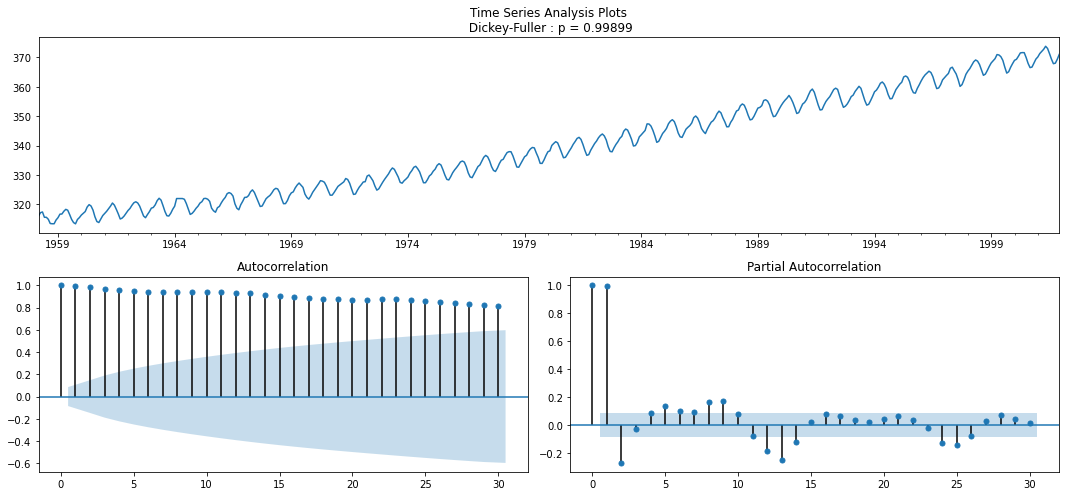

In [76]:
# Bir zaman serisindeki önceki periodların birbirleriyle olan korelasyonlarıdır !!!!
# Çizgilerin içinde kalmaması lazım..(Yuvarlaklar hariç) İstatiki olarak anlamlı değildir !!!!
# P ve Q karar veriyoruz !!!!

# ACF genişliği gecikmelere göre "AZALIYORSA" ve PACF p gecikme sonra "KESILIYORSA" AR(p) modeli olduğu anlamına gelir.

# ACF genişliği q gecikme sonra "KESILIYORSA" ve PACF genişliği gecikmelere göre "AZALIYORSA" MA(q) modeli olduğu anlamına gelir.

# ACF ve PACF'nin genişlikleri gecikmelere göre azalıyorsa, ARMA modeli olduğu anlamına gelir.

# Correlations of previous periods in a time series with each other !!!!
# It should not stay inside the lines. (Except for the circles) It is not statistically significant !!!!
# We decide P and Q !!!!

# IF ACF width "DECREASE" relative to the delays and PACF "CUT" after the p delay means it's an AR(p) pattern.

# If the ACF width q "CUT" after the delay and the PACF width "DECREASE" according to the delays, it means it's a MA(q) pattern.

# If the widths of ACF and PACF are decreasing with respect to the delays, it means it is an ARMA model.

acf_pacf(y)

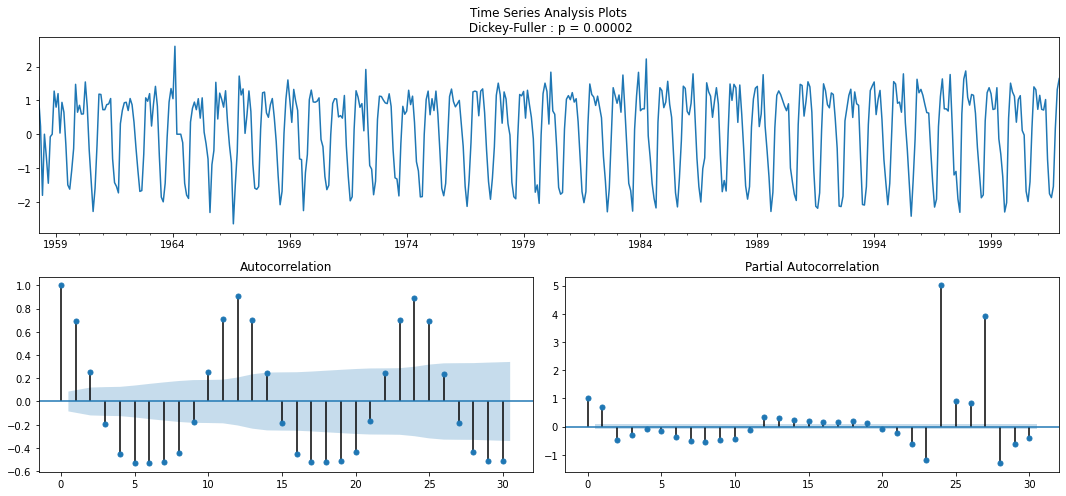

In [77]:
# Yukarıdakiden anlamlı bir çıkarım yapamadım ...

# I couldn't make any meaningful inferences from the above...

acf_pacf(y.diff(1).dropna())

In [78]:
print("Best AIC Order Params : {}".format(arima_best_params_mae))
print("Best MAE Order Params : {}".format(arima_best_params_aic))

Best AIC Order Params : (2, 1, 2)
Best MAE Order Params : (2, 1, 3)


In [79]:
##################################################
# SARIMA(p, d, q): (Seasonal Autoregressive Integrated Moving-Average)
##################################################

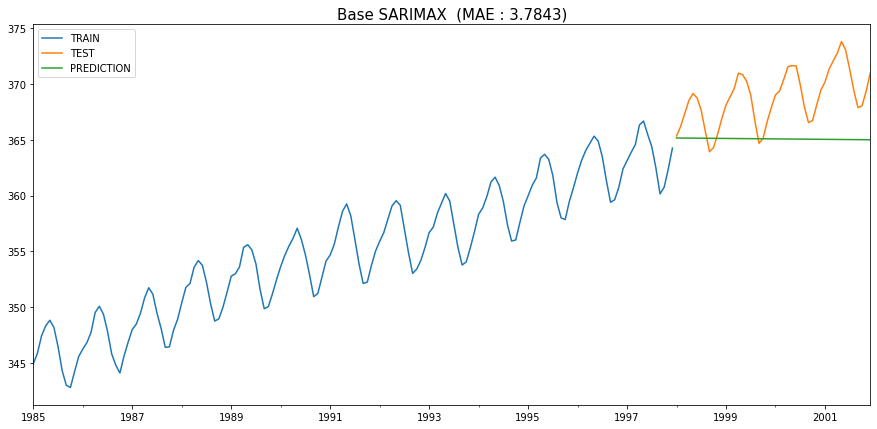

In [80]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train, order = (1,0,1), seasonal_order = (0,0,0,12)).fit(disp = 0)

sarima_y_pred = sarima_model.forecast(48)

plot_co2_graph(train, test, sarima_y_pred, "Base SARIMAX ")

In [81]:
############################
# Hyperparameter Optimization (Determining Model Grades)
############################

In [82]:
p = d = q =range(0,2)
pdq = list(itertools.product(p,d,q))
seaosanal_pdq = [(x[0],x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

In [83]:
def sarima_optimizer_aic(train,pdq,seasonal_pdq):
    
    best_aic, best_order ,best_seasonal_order = float("inf"), None , None
    
    for param in pdq:
        for seasonal_param in seasonal_pdq:
             
                try:
                    sarima_model = SARIMAX(train , order=param, seasonal_order=seasonal_param).fit(disp = 0)
                    sarima_aic = sarima_model.aic
                    
                    if sarima_aic < best_aic :
                        
                        best_aic, best_order, best_seasonal_order = sarima_aic,param,seasonal_param
                    
                    print(f"AIC : {round(sarima_aic,4)},Order : {param},Seasonal Order : {seasonal_param}")
                
                except: 
                    continue
    
    print("\n\n")
    print(f"Best AIC : {round(best_aic,4)},Best Order : {best_order}, Best Seasonal Order : {best_seasonal_order}")
    
    return best_order, best_seasonal_order

In [84]:
def sarima_optimizer_mae(train, test, pdq,seasonal_pdq,steps = 48):
    
    best_mae , best_order, best_seasonal_order = float("inf"), None,None
    
    for param in pdq:
        for seasonal_param in seaosanal_pdq:
            
            try:
                sarima_model = SARIMAX(train, order = param , seasonal_order=seasonal_param).fit(disp = 0)
                sarima_y_pred = sarima_model.forecast(steps = steps)
                sarima_mae = mean_absolute_error(test, sarima_y_pred)
                
                if sarima_mae < best_mae:
                    
                    best_mae, best_order ,best_seasonal_order = sarima_mae, param, seasonal_param
                    
                print(f"MAE : {round(sarima_mae, 4)}, Order : {param}, Seasonal Order : {seasonal_param}")
                
            except:
                continue
                
    print("\n\n")
    print(f"Best MAE : {round(best_mae,4)}, Best Order : {best_order}, Seasonal Order : {best_seasonal_order}")
    
    return best_order, best_seasonal_order

In [85]:
best_mae_order_sarimax, best_mae_seasonal_order_sarimax = sarima_optimizer_mae(train, test, pdq, seaosanal_pdq,steps = 48)

MAE : 368.7634, Order : (0, 0, 0), Seasonal Order : (0, 0, 0, 12)
MAE : 324.1791, Order : (0, 0, 0), Seasonal Order : (0, 0, 1, 12)
MAE : 5.063, Order : (0, 0, 0), Seasonal Order : (0, 1, 0, 12)
MAE : 4.8033, Order : (0, 0, 0), Seasonal Order : (0, 1, 1, 12)
MAE : 5.2062, Order : (0, 0, 0), Seasonal Order : (1, 0, 0, 12)
MAE : 4.8786, Order : (0, 0, 0), Seasonal Order : (1, 0, 1, 12)
MAE : 3.3237, Order : (0, 0, 0), Seasonal Order : (1, 1, 0, 12)
MAE : 1.528, Order : (0, 0, 0), Seasonal Order : (1, 1, 1, 12)
MAE : 364.9179, Order : (0, 0, 1), Seasonal Order : (0, 0, 0, 12)
MAE : 320.4051, Order : (0, 0, 1), Seasonal Order : (0, 0, 1, 12)
MAE : 4.9853, Order : (0, 0, 1), Seasonal Order : (0, 1, 0, 12)
MAE : 4.7653, Order : (0, 0, 1), Seasonal Order : (0, 1, 1, 12)
MAE : 5.0033, Order : (0, 0, 1), Seasonal Order : (1, 0, 0, 12)
MAE : 348.0647, Order : (0, 0, 1), Seasonal Order : (1, 0, 1, 12)
MAE : 3.6742, Order : (0, 0, 1), Seasonal Order : (1, 1, 0, 12)
MAE : 1.5667, Order : (0, 0, 1),

In [86]:
best_aic_order_sarimax, best_aic_seasonal_order_sarimax = sarima_optimizer_aic(train,pdq,seaosanal_pdq)

AIC : 6922.6066,Order : (0, 0, 0),Seasonal Order : (0, 0, 0, 12)
AIC : 6318.3052,Order : (0, 0, 0),Seasonal Order : (0, 0, 1, 12)
AIC : 1643.9997,Order : (0, 0, 0),Seasonal Order : (0, 1, 0, 12)
AIC : 1428.2939,Order : (0, 0, 0),Seasonal Order : (0, 1, 1, 12)
AIC : 1958.5009,Order : (0, 0, 0),Seasonal Order : (1, 0, 0, 12)
AIC : 1648.7784,Order : (0, 0, 0),Seasonal Order : (1, 0, 1, 12)
AIC : 1205.0254,Order : (0, 0, 0),Seasonal Order : (1, 1, 0, 12)
AIC : 973.2077,Order : (0, 0, 0),Seasonal Order : (1, 1, 1, 12)
AIC : 6269.1904,Order : (0, 0, 1),Seasonal Order : (0, 0, 0, 12)
AIC : 5663.5679,Order : (0, 0, 1),Seasonal Order : (0, 0, 1, 12)
AIC : 1229.8448,Order : (0, 0, 1),Seasonal Order : (0, 1, 0, 12)
AIC : 1126.5843,Order : (0, 0, 1),Seasonal Order : (0, 1, 1, 12)
AIC : 1507.5041,Order : (0, 0, 1),Seasonal Order : (1, 0, 0, 12)
AIC : 6249.6219,Order : (0, 0, 1),Seasonal Order : (1, 0, 1, 12)
AIC : 1008.1603,Order : (0, 0, 1),Seasonal Order : (1, 1, 0, 12)
AIC : 767.6333,Order : (0,

In [87]:
########################################################
# Final Model For SARIMAX MAE & AIC
########################################################

In [88]:
def final_sarimax_mae(train,test,best_order,best_seasonal_order, steps = 48):

    final_sarimax_mae = SARIMAX(train, order = best_order, seasonal_order = best_seasonal_order).fit(disp = 0)
    final_y_sarimax_pred = final_sarimax_mae.forecast(steps = steps )
    final_mae = mean_absolute_error(test, final_y_sarimax_pred)
    
    title = f"Optimizer SARIMAX (MAE : {round(final_mae, 4)}, Order : {best_order}, Seasonal Order : {best_seasonal_order})"
    
    plt.figure(figsize = (15,7))
    
    train["1985":].plot(label = "TRAIN")
    test.plot(label = "TEST")
    final_y_sarimax_pred.plot(label = "PREDICTION")
    
    plt.title(title, fontsize = 15)
    plt.legend(loc = "upper left")
    plt.show()

In [89]:
def final_sarimax_aic(train,test,best_order,best_seasonal_order, steps = 48):

    final_sarimax_aic = SARIMAX(train, order = best_order, seasonal_order = best_seasonal_order).fit(disp = 0)
    final_y_sarimax_pred = final_sarimax_aic.forecast(steps = steps )
    final_aic = final_sarimax_aic.aic
    
    title = f"Optimizer SARIMAX (AIC : {round(final_aic, 4)}, Order : {best_order}, Seasonal Order : {best_seasonal_order})"
    
    plt.figure(figsize = (15,7))
    
    train["1985":].plot(label = "TRAIN")
    test.plot(label = "TEST")
    final_y_sarimax_pred.plot(label = "PREDICTION")
    
    plt.title(title, fontsize = 15)
    plt.legend(loc = "upper left")
    plt.show()

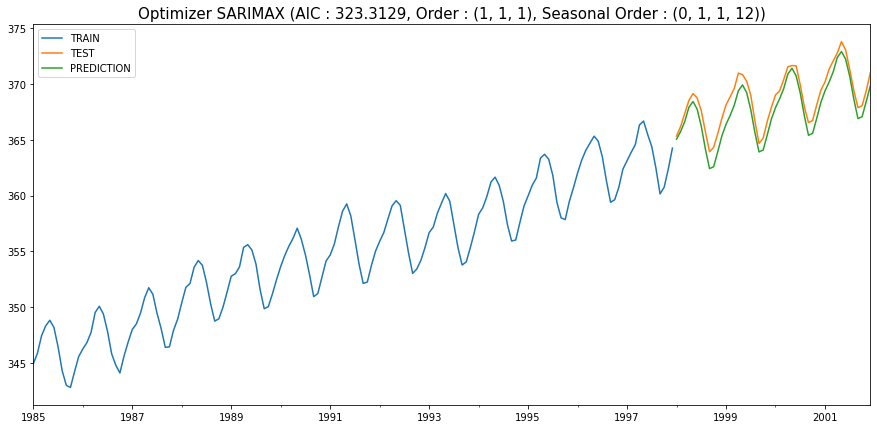

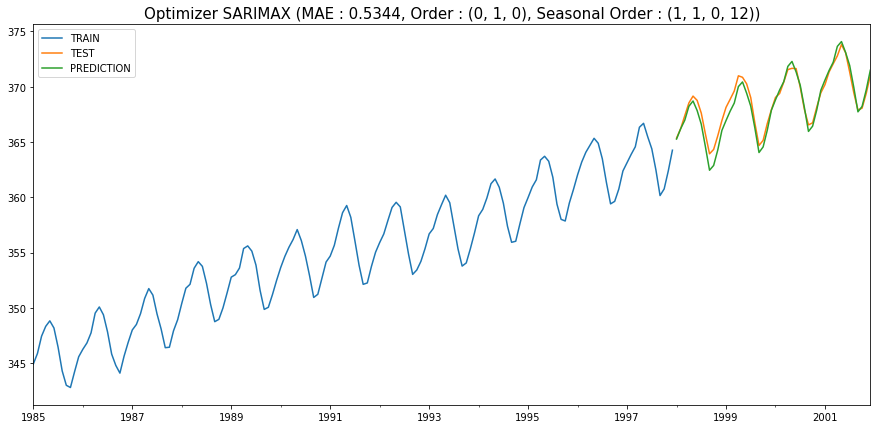

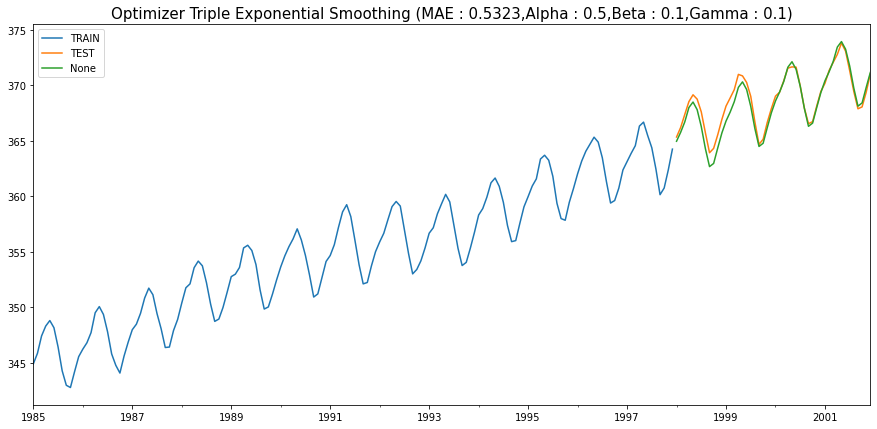

In [90]:
final_sarimax_aic(train, test, best_aic_order_sarimax, best_aic_seasonal_order_sarimax, steps = 48)
final_sarimax_mae(train, test, best_mae_order_sarimax,best_mae_seasonal_order_sarimax, steps = 48)
final_tes_graph(train, test, tes_best_alpha, tes_best_beta, tes_best_gamma)

In [91]:
################################################
# Examining the Statistical Outputs of the Model
################################################

In [92]:
# Best Model 

last_sarimax_model = SARIMAX(train,
                             order = best_mae_order_sarimax, 
                             seasonal_order = best_mae_seasonal_order_sarimax).fit(disp = 0)


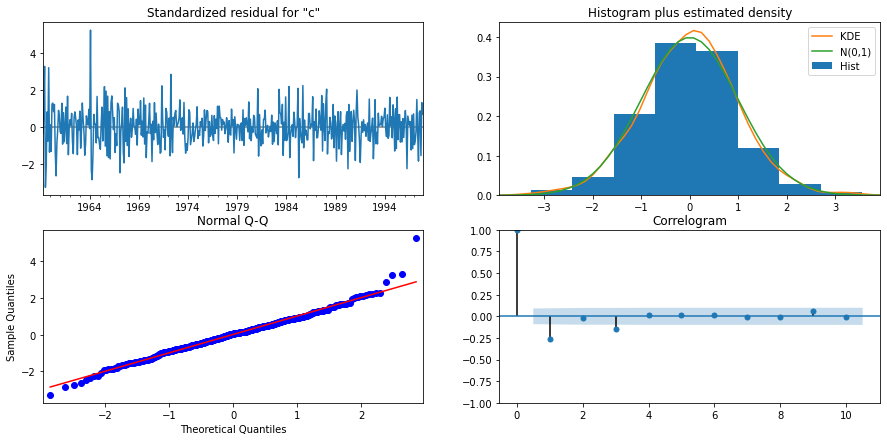

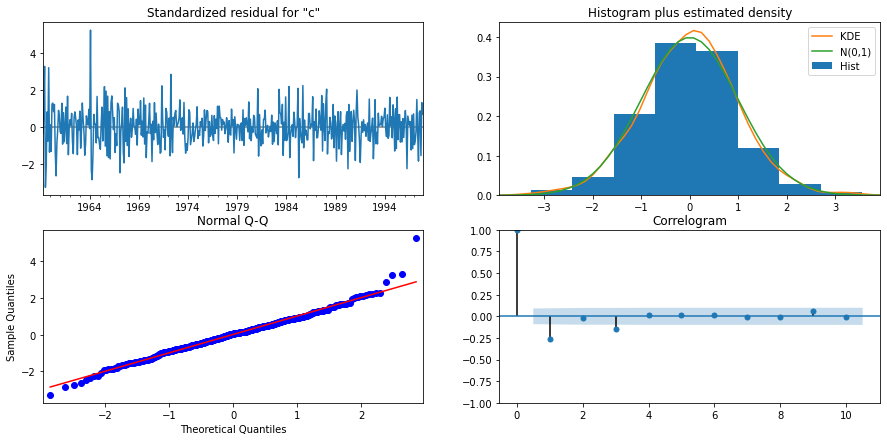

In [93]:
last_sarimax_model.plot_diagnostics(figsize = (15,7))